In [1]:
%matplotlib inline

# Interpreting scikit-learn machine learning models

## Dataset: Current Population Survey from 1985

We will use data from the "Current Population Survey" from 1985 and fetch it from [OpenML](http://openml.org/).

In [2]:
from sklearn.datasets import fetch_openml

censing = fetch_openml(data_id=534, return_frame=True)
censing.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

We can get more information regarding by looking at the description of the dataset.

In [3]:
print(censing.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Determinants of Wages from the 1985 Current Population Survey

Summary:
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. We wish to determine (i) whether wages are related to these characteristics and (ii) whether there is a gender gap in wages.
Based on residual plots, wages were log-transformed to stabilize the variance. Age and work experience were almost perfectly correlated (r=.98). Multiple regression of log wages against sex, age, years of education, work experience, union membership, southern residence, and occupational status showed that these covariates were related to wages (pooled F test, 

The data are stored in a pandas dataframe.

In [4]:
censing.data.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR,WAGE
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married,5.10
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married,4.95
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried,6.67
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried,4.00
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married,7.50


In [5]:
censing.target_names

['WAGE']

The column **WAGE** is our target variable (i.e., the variable which we want to predict). You can note that the dataset contains both numerical and categorical data.

First, let's get some insights by looking at the **marginal** links between the different variables. Only *numerical* variables will be used. 

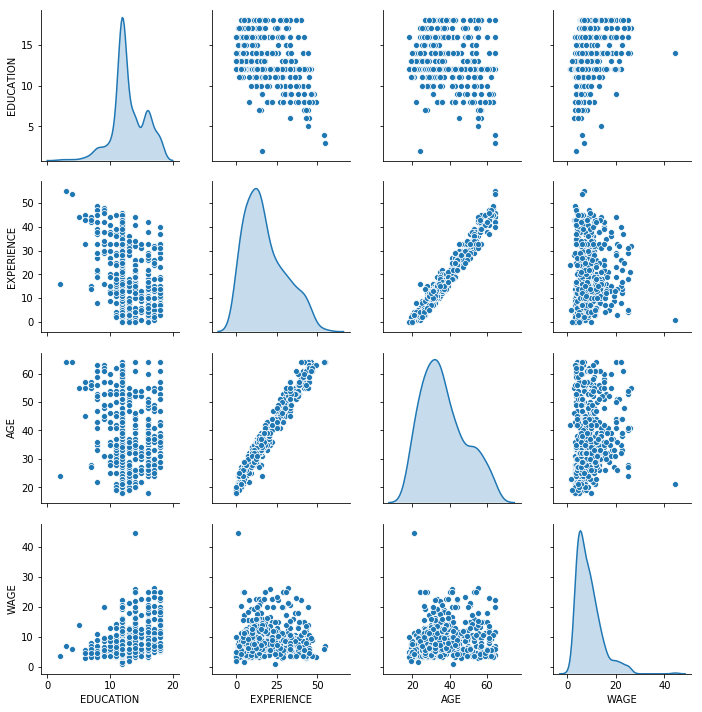

In [6]:
import seaborn as sns

_ = sns.pairplot(censing.data, diag_kind='kde')

We can add some additional information to the previous plots.

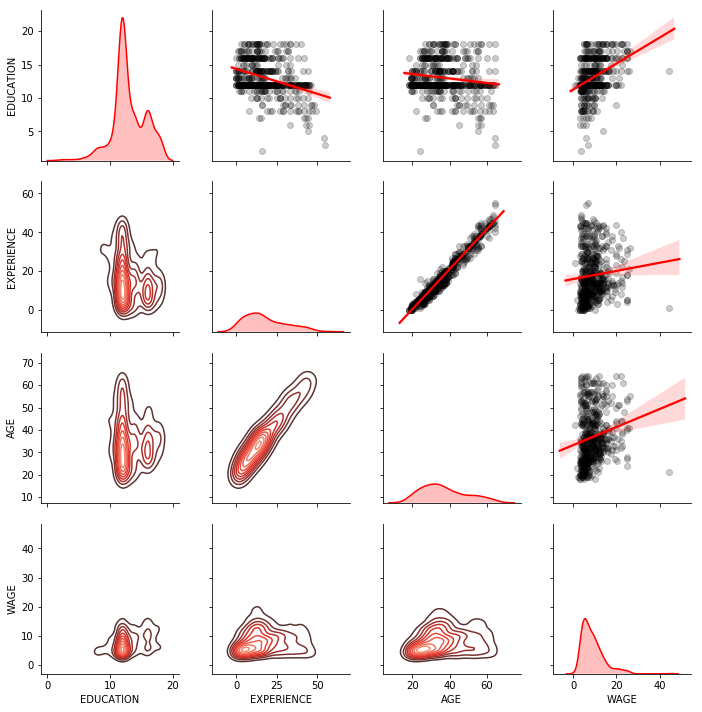

In [7]:
g = sns.PairGrid(censing.data)
g = g.map_upper(
    sns.regplot, scatter_kws={"color": "black", "alpha": 0.2},
    line_kws={"color": "red"}
)
g = g.map_lower(sns.kdeplot, cmap="Reds_d")
g = g.map_diag(sns.kdeplot, shade=True, color='r')

We can already have some intuitions regarding our dataset:

* The "WAGE" distribution has a long tail and we could work by taking the `log` of the wage;
* For all 3 variables, "EDUCATION", "EXPERIENCE", and "AGE", the "WAGE" is increasing when these variables are increasing;
* The "EXPERIENCE" and "AGE" are correlated.

It is important to point out that we analyzed the data by looking at the joint distribution between 2 variables which is a **marginal** link.

We will shortly jump into interpreting the coefficients of linear model. In this regard, we should emphasize that linear models compute **conditional** links. All interpretation of the value coefficient given the relationship between the feature and the target given that other features remain constant. For instance, we can deduce the relationship between the "AGE" and "WAGE" for a given number of year of "EXPERIENCE".

## Interpret coefficients of linear models

In [8]:
X = censing.data[censing.feature_names]
y = censing.data[censing.target_names].values.ravel()

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

We have heterogeneous data and we will need to make a specific preprocessing for each data types.

In [10]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

Thus, the `preprocessor` will:

* one-hot encode (i.e., generate a column by category) the categorical columns;
* replace by 0 and 1 the categories of binary columns;
* keep numerical values as they are.

In [11]:
X_train[:5]

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
204,16.0,no,female,6.0,not_member,28.0,White,Management,Manufacturing,Married
196,16.0,no,female,26.0,not_member,48.0,White,Management,Other,Married
510,17.0,no,female,14.0,not_member,37.0,White,Professional,Other,Married
19,12.0,no,male,33.0,not_member,51.0,White,Other,Other,Married
361,16.0,no,male,21.0,not_member,43.0,White,Service,Other,Married


In [12]:
preprocessor.fit_transform(X_train[:5])

array([[ 1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 16.,  6.,
        28.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 16., 26.,
        48.],
       [ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 17., 14.,
        37.],
       [ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0., 12., 33.,
        51.],
       [ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0., 16., 21.,
        43.]])

We will fit a ridge regressor and transform the target before the fit using a log transform.

In [13]:
import numpy as np
import scipy as sp
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
pipe.fit(X_train, y_train);

We can check the performance of the model which fitted.

In [14]:
from sklearn.metrics import median_absolute_error

y_pred = pipe.predict(X_test)
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f} $/hour')

MAE = 2.07 $/hour


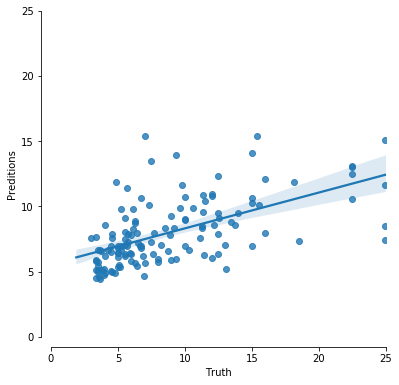

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(y_test, y_pred)
sns.despine(offset=10)
plt.ylabel('Preditions')
plt.xlabel('Truth')
plt.xlim([0, 25])
plt.ylim([0, 25]);

So now, we can plot the values of the coefficients of the regressor which we fitted.

In [16]:
feature_names = (pipe.named_steps['columntransformer']
                     .named_transformers_['onehotencoder']
                     .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR,UNION,SEX,SOUTH,EDUCATION,EXPERIENCE,AGE
Coefficients,-0.009772,-0.009469,0.019241,-0.005062,0.06907,-0.012276,0.058762,-0.035262,-0.075232,0.003371,0.025874,-0.029244,-0.029382,-0.097874,0.080202,-0.031481,0.030608,0.00797,-0.003642


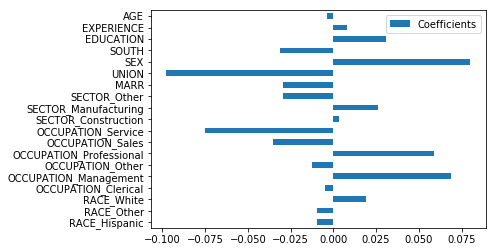

In [17]:
import pandas as pd

coefs = pd.DataFrame(
    pipe.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)

coefs.plot(kind='barh')
coefs.T

The way that we can interpret these values is as follow. An increase of the "AGE" will induce a decrease of the "WAGE" when all other features remain constant or an increase of the "EXPERIENCE" will induce an increase of the "WAGE" when all other features remain constant.

The first interpretation might look counter-intuitive at first, if one relates the relationship between "AGE" and "WAGE" as a *marginal* link. However, as previously mentioned, a linear model computes a *conditional* link between "AGE" and "WAGE" given all other features.

Therefore, one could interpret that for a given experience (and all other features constant as well ...), a younger person would have an higher wage.

One limitation currently is that we cannot compare the different weights since we did not scale the data during fit and that features can have different range.

Text(0.5, 1.0, 'Features std. dev.')

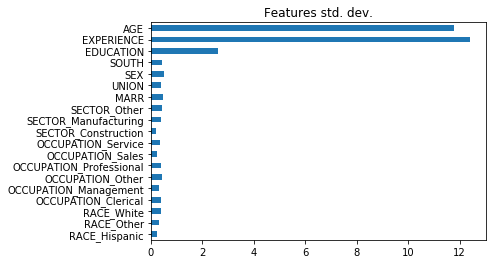

In [18]:
X_train_preprocessed = pd.DataFrame(
    pipe[0].transform(X_train),
    columns=feature_names
)
X_train_preprocessed.std().plot(kind='barh')
plt.title('Features std. dev.')

We can normalize the weights by the standard deviation and then we will be able to compare the different weights.

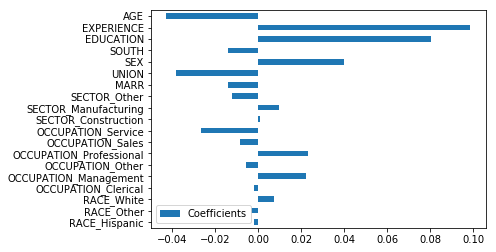

In [19]:
coefs = pd.DataFrame(
    pipe.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(),
    columns=['Coefficients'], index=feature_names
)

coefs.plot(kind='barh')

Another possible way would have been to normalize the data by applying a `StandardScaler` on the numerical features.

Up to know, we did not check the stability of the coefficients and it would be important to check it to ensure through cross-validation.

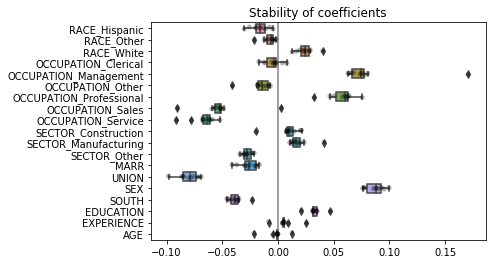

In [20]:
from sklearn.model_selection import cross_validate

cv_pipe = cross_validate(
    pipe, X, y, return_estimator=True, cv=10
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_
     for est in cv_pipe['estimator']],
    columns=feature_names
)

sns.boxplot(data=coefs, orient='h')
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.3)
plt.axvline(x=0, color='.5')
plt.title('Stability of coefficients');

In [23]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeCV

binary_columns = ['RACE', 'OCCUPATION', 'SECTOR', 'MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

pipe = make_pipeline(preprocessor, RidgeCV())

In [24]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose=False)),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None,
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values

In [25]:
from sklearn.metrics import median_absolute_error

y_pred = pipe.predict(X_test)
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f} $/hour')

MAE = 2.47 $/hour


In [26]:
import numpy as np

feature_names = np.hstack([binary_columns, numerical_columns])

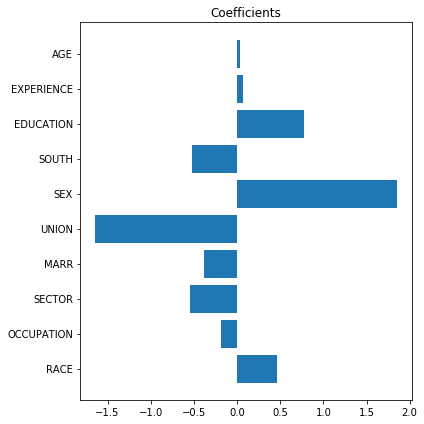

In [27]:
from matplotlib import pyplot as plt

coefs = pipe.named_steps['ridgecv'].coef_.ravel()

plt.figure(figsize=(6, 6))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), feature_names)
plt.title("Coefficients")
plt.tight_layout()

In [28]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeCV

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

pipe = make_pipeline(preprocessor, RidgeCV())

In [29]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['RACE', 'OCCUPATION',
                      

In [30]:
from sklearn.metrics import median_absolute_error

y_pred = pipe.predict(X_test)
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f} $/hour')

MAE = 2.42 $/hour


In [31]:
import numpy as np

feature_names = (pipe.named_steps['columntransformer']
                     .named_transformers_['onehotencoder']
                     .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

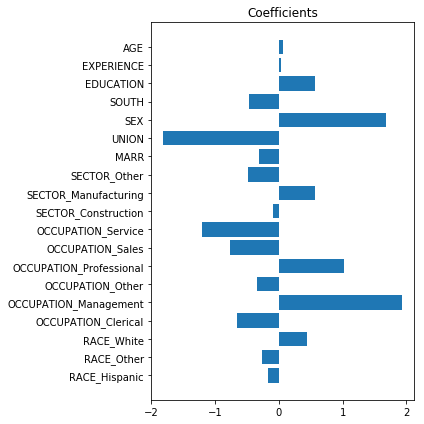

In [32]:
from matplotlib import pyplot as plt

coefs = pipe.named_steps['ridgecv'].coef_.ravel()

plt.figure(figsize=(6, 6))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), feature_names)
plt.title("Coefficients")
plt.tight_layout()

In [33]:
import pandas as pd

X_train_preprocessed = pd.DataFrame(
    pipe[0].transform(X_train),
    columns=feature_names
)
X_train_preprocessed.head()

,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR,UNION,SEX,SOUTH,EDUCATION,EXPERIENCE,AGE
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,16.0,6.0,28.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,16.0,26.0,48.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,17.0,14.0,37.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,12.0,33.0,51.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,16.0,21.0,43.0


In [34]:
X_train_preprocessed.std()

RACE_Hispanic               0.223312
RACE_Other                  0.336725
RACE_White                  0.386740
OCCUPATION_Clerical         0.398611
OCCUPATION_Management       0.319421
OCCUPATION_Other            0.449561
OCCUPATION_Professional     0.396697
OCCUPATION_Sales            0.246835
OCCUPATION_Service          0.355048
SECTOR_Construction         0.212972
SECTOR_Manufacturing        0.382570
SECTOR_Other                0.418105
MARR                        0.475964
UNION                       0.388784
SEX                         0.498814
SOUTH                       0.449561
EDUCATION                   2.629689
EXPERIENCE                 12.394068
AGE                        11.779059
dtype: float64

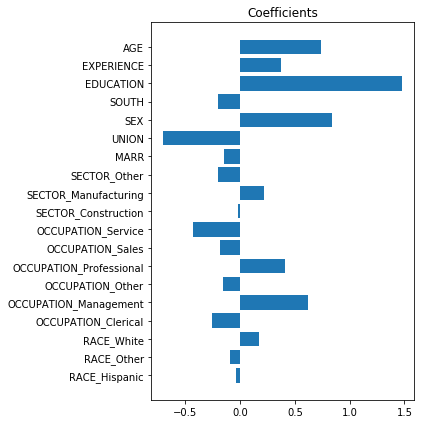

In [35]:
from matplotlib import pyplot as plt

coefs = pipe.named_steps['ridgecv'].coef_.ravel() * X_train_preprocessed.std()

plt.figure(figsize=(6, 6))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), feature_names)
plt.title("Coefficients")
plt.tight_layout()

In [36]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    (StandardScaler(), numerical_columns)
)

pipe = make_pipeline(preprocessor, RidgeCV())

In [37]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['RACE', 'OCCUPATION',
                             

In [38]:
from sklearn.metrics import median_absolute_error

y_pred = pipe.predict(X_test)
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f} $/hour')

MAE = 2.44 $/hour


In [39]:
import numpy as np

feature_names = (pipe.named_steps['columntransformer']
                     .named_transformers_['onehotencoder']
                     .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

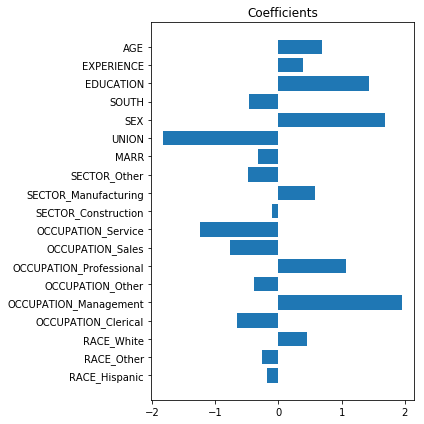

In [40]:
from matplotlib import pyplot as plt

coefs = pipe.named_steps['ridgecv'].coef_.ravel()

plt.figure(figsize=(6, 6))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), feature_names)
plt.title("Coefficients")
plt.tight_layout()

In [41]:
X_train.shape

(400, 10)

In [42]:
X_test.shape

(134, 10)

In [43]:
import scipy as sp
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    (StandardScaler(), numerical_columns)
)

pipe = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(regressor=RidgeCV(), func=np.log10, inverse_func=sp.special.exp10)
)

In [44]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['RACE', 'OCCUPATION',
                             

In [45]:
from sklearn.metrics import median_absolute_error

y_pred = pipe.predict(X_test)
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f} $/hour')

MAE = 2.09 $/hour


In [46]:
import numpy as np

feature_names = (pipe.named_steps['columntransformer']
                     .named_transformers_['onehotencoder']
                     .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

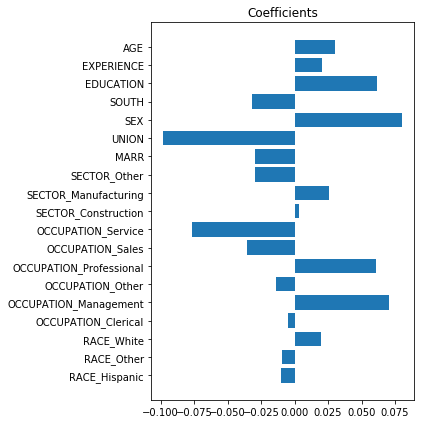

In [47]:
from matplotlib import pyplot as plt

coefs = pipe.named_steps['transformedtargetregressor'].regressor_.coef_.ravel()

plt.figure(figsize=(6, 6))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), feature_names)
plt.title("Coefficients")
plt.tight_layout()

In [48]:
from sklearn.model_selection import cross_validate

In [51]:
cv_pipe = cross_validate(pipe, X, y, return_estimator=True, cv=10)
coefs_ = [est.named_steps['transformedtargetregressor'].regressor_.coef_
          for est in cv_pipe['estimator']]

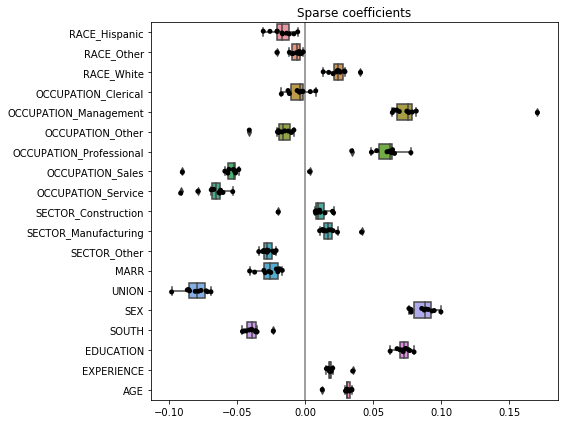

In [57]:
import pandas as pd
coefs_ = pd.DataFrame(coefs_, columns=feature_names)
plt.figure(figsize=(8, 6))
sns.boxplot(data=coefs_, orient='h')
sns.stripplot(data=coefs_, orient='h', color='k')
plt.axvline(x=0, color='.5')  # Add a vertical line at 0
plt.title('Sparse coefficients')
plt.tight_layout()

In [66]:
import scipy as sp
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.compose import TransformedTargetRegressor

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    (StandardScaler(), numerical_columns)
)

pipe = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(max_iter=5000, cv=5), func=np.log10, inverse_func=sp.special.exp10
    )
)

In [67]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['RACE', 'OCCUPATION',
                             

In [68]:
from sklearn.metrics import median_absolute_error

y_pred = pipe.predict(X_test)
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f} $/hour')

MAE = 2.16 $/hour


In [69]:
import numpy as np

feature_names = (pipe.named_steps['columntransformer']
                     .named_transformers_['onehotencoder']
                     .get_feature_names(input_features=categorical_columns))
feature_names = np.hstack([feature_names, binary_columns, numerical_columns])

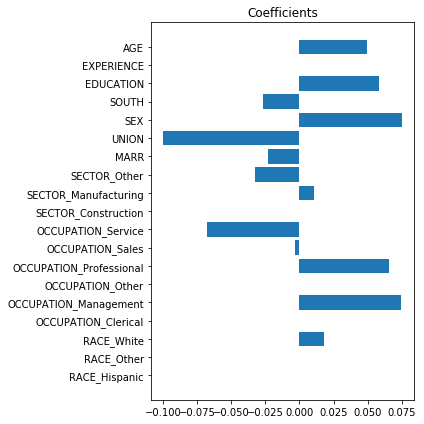

In [70]:
from matplotlib import pyplot as plt

coefs = pipe.named_steps['transformedtargetregressor'].regressor_.coef_.ravel()

plt.figure(figsize=(6, 6))
plt.barh(np.arange(coefs.size), coefs)
plt.yticks(np.arange(coefs.size), feature_names)
plt.title("Coefficients")
plt.tight_layout()

In [71]:
from sklearn.model_selection import cross_validate

In [72]:
cv_pipe = cross_validate(pipe, X, y, return_estimator=True, cv=10)
coefs_ = [est.named_steps['transformedtargetregressor'].regressor_.coef_
          for est in cv_pipe['estimator']]

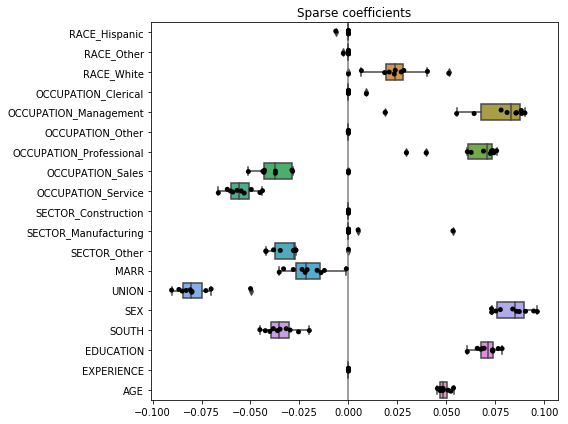

In [73]:
import pandas as pd
coefs_ = pd.DataFrame(coefs_, columns=feature_names)
plt.figure(figsize=(8, 6))
sns.boxplot(data=coefs_, orient='h')
sns.stripplot(data=coefs_, orient='h', color='k')
plt.axvline(x=0, color='.5')  # Add a vertical line at 0
plt.title('Sparse coefficients')
plt.tight_layout()

In [173]:
effect = X_train_preprocessed * coefs
effect_decoded = {}
for cat in categorical_columns:
    cat_cols = effect.columns.str.contains(cat)
    effect_cat = effect.loc[:, cat_cols]
    idx_filter = (effect_cat != 0).values
    effect_decoded[cat] = effect_cat.values[idx_filter]
for col in binary_columns + numerical_columns:
    effect_decoded[col] = effect[col]
effect = pd.DataFrame(effect_decoded)

In [174]:
import seaborn as sns

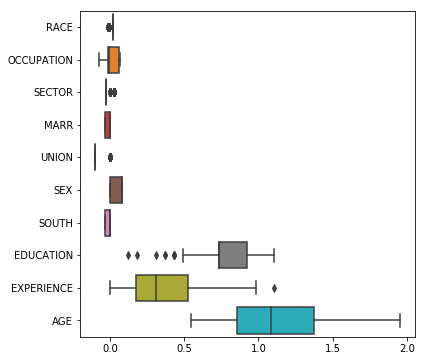

In [175]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=effect, orient='h', ax=ax)


Partial Dependence Plots

Partial dependence plots show the dependence between the target function [2]_
and a set of 'target' features, marginalizing over the
values of all other features (the complement features). Due to the limits
of human perception the size of the target feature set must be small (usually,
one or two) thus the target features are usually chosen among the most
important features.

This example shows how to obtain partial dependence plots from a
:class:`~sklearn.neural_network.MLPRegressor` and a
:class:`~sklearn.ensemble.HistGradientBoostingRegressor` trained on the
California housing dataset. The example is taken from [1]_.

The plots show four 1-way and two 1-way partial dependence plots (ommitted for
:class:`~sklearn.neural_network.MLPRegressor` due to computation time).
The target variables for the one-way PDP are: median income (`MedInc`),
average occupants per household (`AvgOccup`), median house age (`HouseAge`),
and average rooms per household (`AveRooms`).

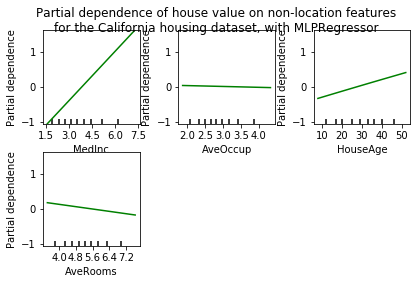

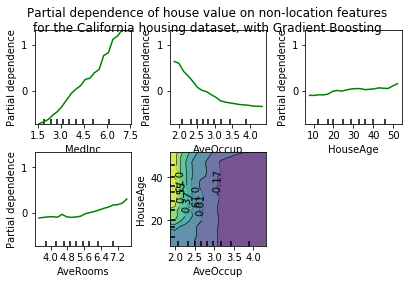

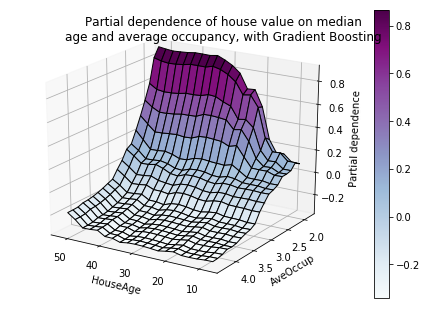

In [4]:
"""
========================
Partial Dependence Plots
========================

Partial dependence plots show the dependence between the target function [2]_
and a set of 'target' features, marginalizing over the
values of all other features (the complement features). Due to the limits
of human perception the size of the target feature set must be small (usually,
one or two) thus the target features are usually chosen among the most
important features.

This example shows how to obtain partial dependence plots from a
:class:`~sklearn.neural_network.MLPRegressor` and a
:class:`~sklearn.ensemble.HistGradientBoostingRegressor` trained on the
California housing dataset. The example is taken from [1]_.

The plots show four 1-way and two 1-way partial dependence plots (ommitted for
:class:`~sklearn.neural_network.MLPRegressor` due to computation time).
The target variables for the one-way PDP are: median income (`MedInc`),
average occupants per household (`AvgOccup`), median house age (`HouseAge`),
and average rooms per household (`AveRooms`).

.. [1] T. Hastie, R. Tibshirani and J. Friedman,
    "Elements of Statistical Learning Ed. 2", Springer, 2009.

.. [2] For classification you can think of it as the regression score before
       the link function.
"""
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets.california_housing import fetch_california_housing


##############################################################################
# California Housing data preprocessing
# -------------------------------------
#
# Center target to avoid gradient boosting init bias: gradient boosting
# with the 'recursion' method does not account for the initial estimator
# (here the average target, by default)
#
cal_housing = fetch_california_housing()
names = cal_housing.feature_names
X, y = cal_housing.data, cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

##############################################################################
# Partial Dependence computation
# ------------------------------
#
# Let's fit the models and compute the partial dependence plots either
# or one or two variables at a time.

print("Training MLPRegressor...")
tic = time()
est = make_pipeline(#QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(10, 10),
                                 learning_rate_init=0.01,
                                 max_iter=200,
                                 early_stopping=True,
                                 n_iter_no_change=10,
                                 validation_fraction=0.1))
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

print('Computing partial dependence plots...')
tic = time()
# We don't compute the 2-way PDP (5, 1) here, because it is a lot slower
# with the brute method.
features = [0, 5, 1, 2]
plot_partial_dependence(est, X_train, features, feature_names=names,
                        n_jobs=3, grid_resolution=20)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with MLPRegressor')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print("Training GradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor(max_iter=100, max_leaf_nodes=64,
                                    learning_rate=0.1, random_state=1)
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

print('Computing partial dependence plots...')
tic = time()
features = [0, 5, 1, 2, (5, 1)]
plot_partial_dependence(est, X_train, features, feature_names=names,
                        n_jobs=3, grid_resolution=20)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

##############################################################################
# Analysis of the plots
# ---------------------
#
# We can clearly see that the median house price shows a linear relationship
# with the median income (top left) and that the house price drops when the
# average occupants per household increases (top middle).
# The top right plot shows that the house age in a district does not have
# a strong influence on the (median) house price; so does the average rooms
# per household.
# The tick marks on the x-axis represent the deciles of the feature values
# in the training data.
#
# We also observe that :class:`~sklearn.neural_network.MLPRegressor` has much
# smoother predictions than
# :class:`~sklearn.ensemble.HistGradientBoostingRegressor`. For the plots to be
# comparable, it is necessary to subtract the average value of the target
# ``y``: The 'recursion' method, used by default for
# :class:`~sklearn.ensemble.HistGradientBoostingRegressor`, does not account
# for the initial predictor (in our case the average target). Setting the
# target average to 0 avoids this bias.
#
# Partial dependence plots with two target features enable us to visualize
# interactions among them. The two-way partial dependence plot shows the
# dependence of median house price on joint values of house age and average
# occupants per household. We can clearly see an interaction between the
# two features: for an average occupancy greater than two, the house price is
# nearly independent of the house age, whereas for values less than two there
# is a strong dependence on age.

##############################################################################
# 3D interaction plots
# --------------------
#
# Let's make the same partial dependence plot for the 2 features interaction,
# this time in 3 dimensions.

fig = plt.figure()

target_feature = (1, 5)
pdp, axes = partial_dependence(est, X_train, target_feature,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
             'age and average occupancy, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

plt.show()


Permutation Importance with Multicollinear Features

.. currentmodule:: sklearn.inspection

In this example, we compute the permutation importance on the Wisconsin
breast cancer dataset using :func:`permutation_importance`.
The :class:`sklearn.ensemble.RandomForestClassifier` can easily get about 97%
accuracy on a test dataset with a unsurprising tree based feature importance
graph. Because this dataset contains multicollinear features, the permutation
importance will show that none of the features are important.
We handle the multicollinearity by performing hierarchical clustering on the
features' Spearman rank-order correlations, picking a threshold, and keeping a
single feature from each cluster.

.. note::
    See also
    :ref:`sphx_glr_auto_examples_inspection_plot_permutation_importance.py`

Accuracy on test data: 0.97


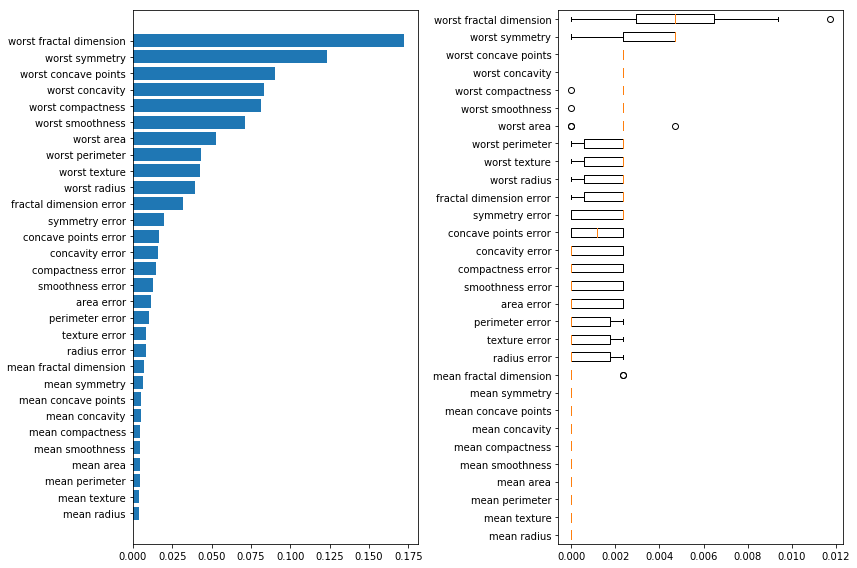

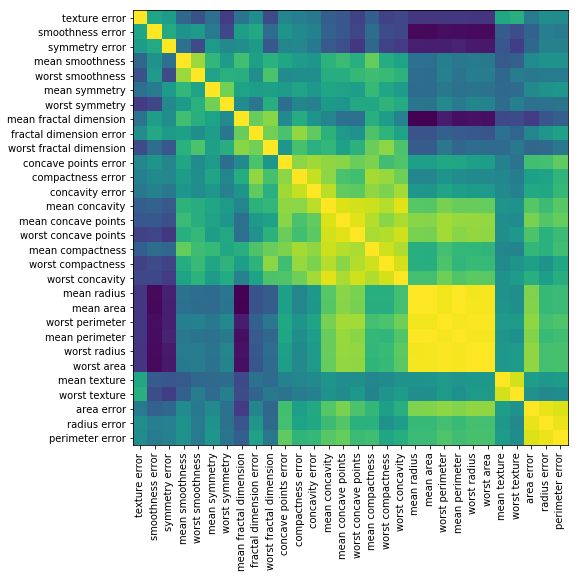

Accuracy on test data with features removed: 0.97


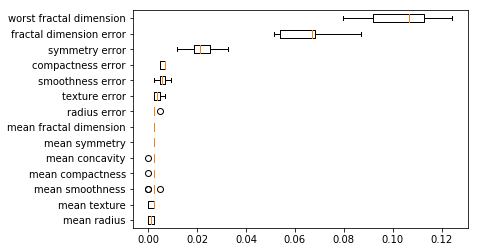

In [4]:
"""
===================================================
Permutation Importance with Multicollinear Features
===================================================

.. currentmodule:: sklearn.inspection

In this example, we compute the permutation importance on the Wisconsin
breast cancer dataset using :func:`permutation_importance`.
The :class:`sklearn.ensemble.RandomForestClassifier` can easily get about 97%
accuracy on a test dataset with a unsurprising tree based feature importance
graph. Because this dataset contains multicollinear features, the permutation
importance will show that none of the features are important.
We handle the multicollinearity by performing hierarchical clustering on the
features' Spearman rank-order correlations, picking a threshold, and keeping a
single feature from each cluster.

.. note::
    See also
    :ref:`sphx_glr_auto_examples_inspection_plot_permutation_importance.py`
"""
print(__doc__)
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

##############################################################################
# Random Forest Feature Importance on Breast Cancer Data
# ------------------------------------------------------
# First, we train a random forest on the breast cancer dataset and evaluate
# its accuracy on a test set:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

##############################################################################
# Next, we plot the tree based feature importance and the permutation
# importance. The permutation importance plot shows that permuting a feature
# drops the accuracy by at most `0.012`, which would suggest that none of the
# features are important. This is in contradiction with the high test accuracy
# computed above: some feature must be important. The permutation importance
# is calculated on the training set to show how much the model relies on each
# feature during training.
perm_importance = permutation_importance(clf, X_train, y_train, n_rounds=10,
                                         random_state=42)
perm_sorted_idx = np.mean(perm_importance, axis=-1).argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indicies = np.arange(1, len(clf.feature_importances_) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indicies, clf.feature_importances_[tree_importance_sorted_idx])
ax1.set_yticklabels(data.feature_names)
ax1.set_yticks(tree_indicies)
ax2.boxplot(perm_importance[perm_sorted_idx].T, vert=False,
            labels=data.feature_names)
fig.tight_layout()
plt.show()

##############################################################################
# Handling Multicollinear Features
# --------------------------------
# When features are collinear, permutating one feature will have little
# effect on the models performance because it can get the same information
# from a correlated feature. One way to handle multicollinear features is by
# performing hierarchical clustering on the Spearman rank-order correlations,
# picking a threshold, and keeping a single feature from each cluster. First,
# we plot a heatmap of the correlated features:
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, no_plot=True)
dendro_order = np.array(dendro['ivl'], dtype='int')
dendro_idx = np.arange(0, len(dendro_order))

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(corr[dendro_order, :][:, dendro_order])
ax.set_xticks(dendro_idx)
ax.set_yticks(dendro_idx)
ax.set_xticklabels(data.feature_names[dendro_order], rotation='vertical')
ax.set_yticklabels(data.feature_names[dendro_order])
plt.show()

##############################################################################
# Next, we pick a threshold to group our features into clusters and choose a
# feature from each cluster to keep, select those features from our dataset,
# and train a new random forest. The test accuracy of the new random forest did
# not changed much compared to the random forest trained on the complete
# dataset.
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

##############################################################################
# Lastly, we plot the permutation importance with new random forest on the
# test dataset.
perm_importance_sel = permutation_importance(clf_sel, X_train_sel,
                                             y_train, n_rounds=10,
                                             random_state=42)
perm_sorted_sel_idx = np.mean(perm_importance_sel, axis=-1).argsort()
_, ax = plt.subplots()
ax.boxplot(perm_importance_sel[perm_sorted_sel_idx].T, vert=False,
           labels=data.feature_names[selected_features])
plt.show()